# imports 

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

from typing import List, Callable, Dict

import sys
import os

#https://github.com/FAU-DLM/wsi_processing_pipeline
sys.path.append("../")
sys.path.append("../wsi_processing_pipeline/")
sys.path.append("../wsi_processing_pipeline/tile_extraction")
sys.path.append("../wsi_processing_pipeline/shared")
import wsi_processing_pipeline
import tile_extraction
import preprocessing
import postprocessing
import shared
from wsi_processing_pipeline.shared import roi
from wsi_processing_pipeline.tile_extraction import tiles, util, slide, filter
from wsi_processing_pipeline.preprocessing import *
import wsi_processing_pipeline.preprocessing.files_getter
import wsi_processing_pipeline.preprocessing.name_getter
from wsi_processing_pipeline.preprocessing.name_getter import NameGetter
from wsi_processing_pipeline.preprocessing.tile_image_block import TileImage, label_tl_image, tile_image, TileTransform
from wsi_processing_pipeline.preprocessing.tile_image_block import show_batch, TileImageBlock
from shared.patient_manager import PatientManager
from shared.enums import DatasetType, EvaluationLevel

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *


import fastai
from fastai.vision.all import *
from typing import Dict
import pandas
import pandas as pd
import numpy as np
import os
import torch
torch.backends.cudnn.benchmark=True
import torchvision
from torchvision.models import *
from torchsummary import summary
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg
import shutil

# to fix python OSError: broken data stream when reading image file
# https://stackoverflow.com/questions/42462431/oserror-broken-data-stream-when-reading-image-file
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from tqdm.notebook import tqdm

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]


from concurrent.futures import as_completed, ProcessPoolExecutor
from tqdm import tqdm

#against DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/')
PATH_DNET = PATH/'DNETs'
PATH_DNET_WSIS = PATH_DNET/'wsis'
PATH_GANGLIOGLIOMA = PATH/'Ganglioglioma'


seed = 42
np.random.seed(seed)

# data

## wsi and json paths

In [8]:
wsi_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET_WSIS, extensions=['.ndpi'])
wsi_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.ndpi'])
wsi_paths = list(wsi_paths_dnets+wsi_paths_ganglioglioma)

json_paths_dnets = fastai.data.transforms.get_files(path=PATH_DNET, extensions=['.json'])
json_paths_ganglioglioma = fastai.data.transforms.get_files(path=PATH_GANGLIOGLIOMA, extensions=['.json'])
json_paths = list(json_paths_dnets+json_paths_ganglioglioma)

In [9]:
print(len(wsi_paths_dnets))
print(len(json_paths_dnets))
print(len(wsi_paths_ganglioglioma))
print(len(json_paths_ganglioglioma))

55
52
176
167


## wsi path to json file mapping and roi creation

In [30]:
def get_json_path_for_wsi(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])->pathlib.Path:
    """
    Arguments:
        wsi_path: path to whole-slide image
        json_paths: a list of paths to all json files, which contain the coordinates of region of interests of the
                    corresponding wsi
    Returns:
        Returns path of corresponding json file or raises FileNotFoundError, if json file cannot be found in json_paths
    """
    wsi_name = wsi_path.stem
    for jp in json_paths:
        if(wsi_name == jp.stem):
            return jp
    
    raise FileNotFoundError(f'json file could not be found for {wsi_path}')

        
def get_rois_from_wsi_path(wsi_path:pathlib.Path, json_paths:List[pathlib.Path])\
                            ->List[wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon]:
    json_path = get_json_path_for_wsi(wsi_path=wsi_path, json_paths=json_paths)
    return roi.get_list_of_RegionOfInterestPolygon_from_json(json_path=json_path)

In [31]:
wsi_paths_all_without_corresponding_json_file = []
wsi_path_to_json_path = {}

for wp in wsi_paths:
    try:
        json_path = get_json_path_for_wsi(wsi_path=wp, json_paths=json_paths)
        wsi_path_to_json_path[wp] = json_path
        
        #if(json_path in duplicates):
        #if(json_path in jps):
        #    print(wp)
        #jps.append(json_path)
    except FileNotFoundError:
        wsi_paths_all_without_corresponding_json_file.append(wp)

In [32]:
wsi_paths_all_without_corresponding_json_file

[Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1365-13-I2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I13.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1684 18-I8.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/DNETs/wsis/N1825-18-I7.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N164-19-5.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N402-16.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N829-17-IV2.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II3.1.ndpi'),
 Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/Ganglioglioma/tumor_ja/WSIs mit beschädigten Tiles/N1531-15-II6.ndpi'),
 Path('/home/Deep_Learner/p

In [33]:
wsi_paths_with_json_files = list(wsi_path_to_json_path.keys())

In [34]:
wsi_path_to_rois = {}
for wp in wsi_paths_with_json_files:
    wsi_path_to_rois[wp] = get_rois_from_wsi_path(wsi_path=wp, json_paths=json_paths)

/home/Deep_Learner/private/DNET_vs_Ganglioglioma/../wsi_processing_pipeline/shared/roi.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sub_polygon_vertices_array = np.array(sub_polygon_vertices).squeeze()
/home/Deep_Learner/private/DNET_vs_Ganglioglioma/../wsi_processing_pipeline/shared/roi.py:161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  polygons.append(__PolygonHelper(level=0, vertices=np.array(vertices).squeeze()))


## id and label funcs

In [35]:
# one case per patient => patient id == case id
def get_patient_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return get_case_id_from_wsi_path(wsi_path=wsi_path)
    
def get_case_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    if('casus' in str(wsi_path.stem)):
        return wsi_path.stem
    split = wsi_path.stem.split('-')
    return f'{split[0]}-{split[1]}'    

def get_slide_id_from_wsi_path(wsi_path:pathlib.Path)->str:
    return wsi_path.stem

def get_labels_from_wsi_path(wsi_path:pathlib.Path, roi=None)->List[int]:
    if('Ganglioglioma' in str(wsi_path.parent)):
        return ['Ganglioglioma']
    if('DNETs' in str(wsi_path)):
        return ['DNET']
    raise AssertionError(f'No label could be determinated for {wsi_path}')

## tiles

In [ ]:
#tilesummaries = tiles.WsisToTilesParallel(wsi_paths=wsi_path_to_json_path.keys(),
#                                          shifted_grid=False,
#                                          tile_height=1024, 
#                                          tile_width=1024, 
#                                          minimal_acceptable_tile_height=0.7, 
#                                          minimal_acceptable_tile_width=0.7,
#                                          tile_scoring_function=tiles.scoring_function_2,
#                                          tile_score_thresh=0.2, 
#                                          level=0, 
#                                          wsi_path_to_rois=wsi_path_to_rois ,
#                                          minimal_tile_roi_intersection_ratio=0.9, 
#                                          verbose=False)


tilesummaries = tiles.WsisToTilesParallel(wsi_paths=random.sample(list(wsi_path_to_json_path.keys()), 4),
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          wsi_path_to_rois=wsi_path_to_rois,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False, 
                                          grids_per_roi=1)


#tilesummaries = tiles.WsisToTilesParallel(wsi_paths=list(wsi_path_to_json_path.keys())[20:25],
#                                          shifted_grid=False,
#                                          tile_height=1024, 
#                                          tile_width=1024, 
#                                          minimal_acceptable_tile_height=0.7, 
#                                          minimal_acceptable_tile_width=0.7,
#                                          tile_scoring_function=tiles.scoring_function_2,
#                                          tile_score_thresh=0.2, 
#                                          level=0, 
#                                          wsi_path_to_rois=wsi_path_to_rois ,
#                                          minimal_tile_roi_intersection_ratio=0.9, 
#                                          verbose=False)

#tilesummaries = tiles.WsisToTilesParallel(wsi_paths=list(wsi_path_to_json_path.keys())[20:25],
#                                          shifted_grid=False,
#                                          tile_height=8192, 
#                                          tile_width=8192, 
#                                          minimal_acceptable_tile_height=0.7, 
#                                          minimal_acceptable_tile_width=0.7,
#                                          tile_scoring_function=tiles.scoring_function_2,
#                                          tile_score_thresh=-1, 
#                                          level=0, 
#                                          wsi_path_to_rois=None ,
#                                          minimal_tile_roi_intersection_ratio=0.9, 
#                                          verbose=False)

In [49]:
type(list(wsi_path_to_rois.values())[0][0])

wsi_processing_pipeline.shared.roi.RegionOfInterestPolygon

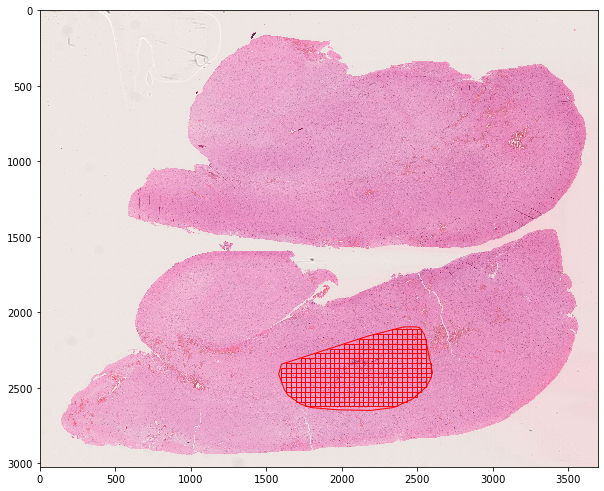

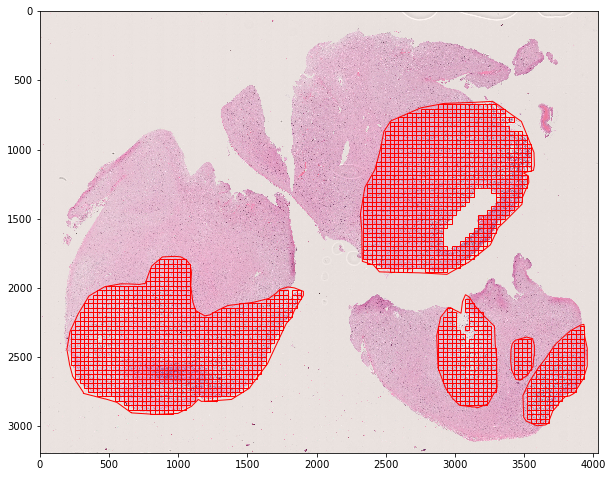

In [17]:
for ts in random.sample(tilesummaries, 2):
    ts.show_wsi_with_top_tiles()

In [47]:
wsi_path = wsi_paths[0]
rois = wsi_path_to_rois[wsi_path]

In [48]:
ts = tiles.WsiToTiles(wsi_path=wsi_path,
                                          tile_height=1024, 
                                          tile_width=1024, 
                                          tile_scoring_function=tiles.scoring_function_2,
                                          tile_score_thresh=0.2, 
                                          level=0, 
                                          rois=rois,
                                          minimal_tile_roi_intersection_ratio=0.9, 
                                          verbose=False, 
                                          grids_per_roi=1)

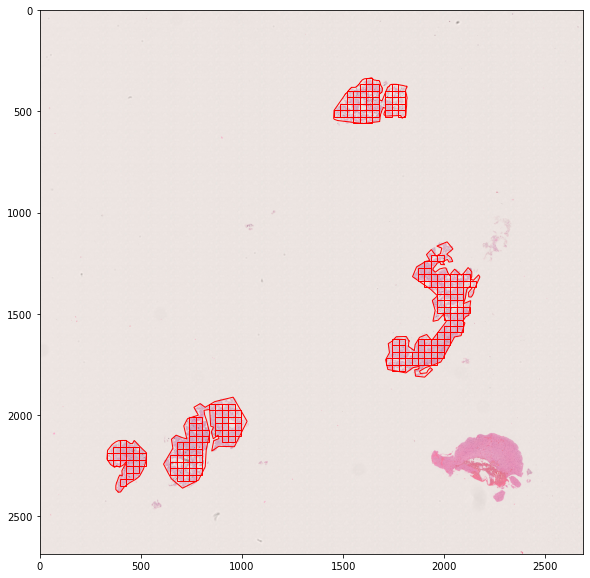

In [50]:
ts.show_wsi_with_top_tiles()

## patient manager 

In [51]:
patient_manager = PatientManager()

In [52]:
patient_manager.create_from_tilesummaries(tilesummaries=tilesummaries, 
                                          patient_id_getter=get_patient_id_from_wsi_path, 
                                          case_id_getter=get_case_id_from_wsi_path, 
                                          slide_id_getter=get_slide_id_from_wsi_path, 
                                          labels_getter=get_labels_from_wsi_path)

0it [00:00, ?it/s]


In [53]:
train_size = 0.85
validation_size = 0.15
test_size = 0.0

patient_manager.split(train_size=train_size, validation_size=validation_size, test_size=test_size, random_state=seed)

ValueError: With n_samples=0, test_size=None and train_size=0.85, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
class_distribution_all_tiles = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [ ]:
class_distribution_all_tiles

In [ ]:
class_distribution_all_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [ ]:
class_distribution_all_slides

In [ ]:
class_distribution_all_cases = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.case, 
                                                            dataset_type=shared.enums.DatasetType.all)

In [ ]:
class_distribution_all_cases

In [54]:
class_distribution_train = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.train)

In [55]:
class_distribution_train

(0, {}, {})

In [56]:
class_distribution_valid = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.tile, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [57]:
class_distribution_valid

(0, {}, {})

In [58]:
class_distribution_valid_slides = patient_manager.get_class_distribution(level=shared.enums.EvaluationLevel.slide, 
                                                            dataset_type=shared.enums.DatasetType.validation)

In [59]:
class_distribution_valid_slides

(0, {}, {})

## data block api

In [43]:
final_size = 512
bs = 35

data = fastai.data.block.DataBlock(
        blocks=(TileImageBlock, fastai.data.block.MultiCategoryBlock),
        get_x=lambda x: x, 
        get_y=lambda x: x.get_labels(),
        splitter=fastai.data.transforms.FuncSplitter(lambda x: x.get_dataset_type() == shared.enums.DatasetType.validation),
        item_tfms=fastai.vision.augment.Resize(size=final_size, method = 'squish'),
        batch_tfms=fastai.vision.augment.aug_transforms(flip_vert=True))

dls = data.dataloaders(patient_manager.get_tiles(dataset_type=DatasetType.train)\
                        +patient_manager.get_tiles(dataset_type=DatasetType.validation), 
                       bs=bs, 
                       verbose=False)

In [ ]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.train))

In [ ]:
len(dls.train_ds)

In [ ]:
len(patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation))

In [ ]:
len(dls.valid_ds)

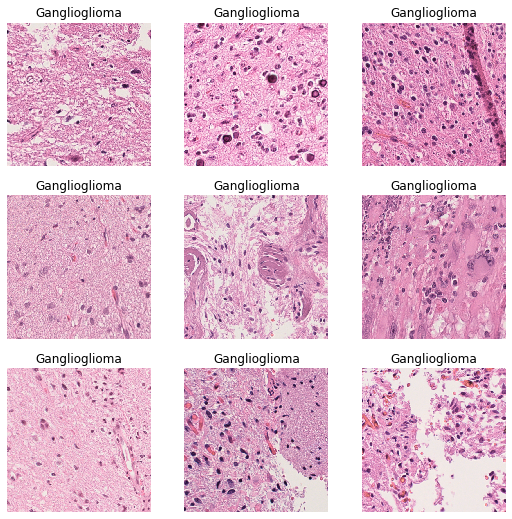

In [26]:
dls.show_batch()

# learner

## n

In [19]:
n=1

## create

In [20]:
#arch = torchvision.models.resnet.resnext101_32x8d
arch = torchvision.models.resnet50

In [60]:
learner = cnn_learner(dls=dls, 
                     arch=arch, 
                     metrics=[fastai.metrics.accuracy_multi],
                     pretrained=True,
                     path=PATH/'models'/f'{n}-{arch.__name__}')

In [61]:
learner.to_fp16()

In [62]:
learner.path

Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/1-resnet50')

In [63]:
learner.path.parent.mkdir(exist_ok=True)

In [64]:
learner.path.mkdir(exist_ok=True)

## name

In [65]:
epochs_frozen = 5
epochs_unfrozen = 10

In [66]:
nameBase = f'{n}-{arch.__name__}'
nameBase

'1-resnet50'

## train

In [ ]:
learner.lr_find(start_lr=1e-15, end_lr=10, num_it=200)

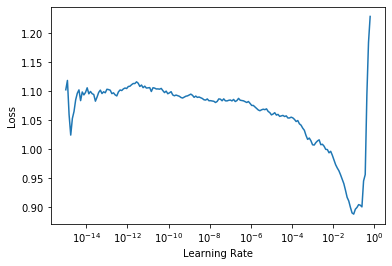

In [41]:
learner.recorder.plot_lr_find()

In [36]:
lr1 = 1e-2

In [37]:
log_head_name = 'log-head.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_frozen, 
                      lr_max=lr1, 
                      cbs=[CSVLogger(fname=log_head_name, append=True), SaveModelCallback(every_epoch=True, fname='head')])

In [45]:
pd.read_csv(learner.path/log_head_name)

epoch           train_loss           valid_loss      accuracy_multi  \
0      0    1.102658987045288                07:54                 NaN   
1  epoch           train_loss           valid_loss      accuracy_multi   
2      0   0.1272624433040619   0.3058910369873047  0.8797662258148193   
3      1  0.08808394521474838   0.2312178760766983   0.941998302936554   
4      2  0.05362435802817345  0.35570651292800903  0.9329529404640198   
5      3  0.03311864286661148   0.2640641927719116   0.939521312713623   
6      4  0.03425982967019081  0.34742024540901184  0.9323685169219971   

       time  
0       NaN  
1      time  
2  31:23:05  
3  29:50:28  
4  29:06:20  
5  15:10:05  
6  20:39:57

In [ ]:
nameHead = f'{nameBase}-head';nameHead

In [ ]:
learner.save(nameHead)

In [48]:
learner.unfreeze()

In [ ]:
learner.lr_find(start_lr=1e-11, end_lr=1e-2, num_it=500)

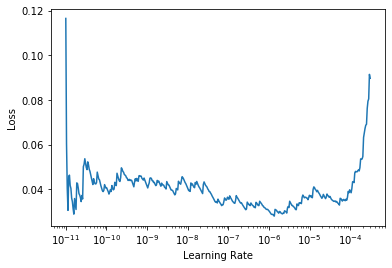

In [55]:
learner.recorder.plot_lr_find()

In [56]:
lr2 = 1e-8
lr3 = 1e-7
lr4 = 1e-6

In [43]:
log_complete_name = 'log-complete.csv'

In [ ]:
learner.fit_one_cycle(n_epoch=epochs_unfrozen, 
                      lr_max=[lr2, lr3, lr4], 
                      cbs=[CSVLogger(fname=log_complete_name, append=True), SaveModelCallback(every_epoch=True, fname='complete')])

In [ ]:
pd.read_csv(learner.path/log_complete_name)

In [67]:
nameComplete = f'{nameBase}-complete'; nameComplete

'1-resnet50-complete'

In [68]:
#learner.save(nameComplete)
learner.load(nameComplete)

# prediction

In [110]:
from postprocessing.predictor import Predictor

In [111]:
predictor = Predictor(learner=learner, patient_manager=patient_manager)

In [112]:
from preprocessing import tile_image_block

In [ ]:
predictor.predict_on_tiles(prediction_type=shared.enums.PredictionType.tiles_on_the_fly, 
                          dataset_type=shared.enums.DatasetType.validation,
                          tile_size=final_size, 
                          batch_size=bs)

In [176]:
thresholds = {'DNET':0.5, 'Ganglioglioma':0.5}
predictor.calculate_predictions_up_to_case_level(dataset_type=shared.enums.DatasetType.validation,
                                                thresholds = thresholds)

../wsi_processing_pipeline/postprocessing/predictor.py:296: RuntimeWarning: invalid value encountered in true_divide
  preds_raw = summed_up_raw_preds/tile_count
../wsi_processing_pipeline/postprocessing/predictor.py:297: RuntimeWarning: invalid value encountered in greater_equal
  preds_thresh = preds_raw >= np.array(list(thresholds.values()))


In [177]:
for t in patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation):
    print(f'y_true: {t.get_labels()}')
    print(f'prediction: {t.predictions_raw}')

y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(5.0251e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(7.8279e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9996), 'Ganglioglioma': tensor(0.0004)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9866), 'Ganglioglioma': tensor(0.0134)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9382), 'Ganglioglioma': tensor(0.0618)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0478), 'Ganglioglioma': tensor(0.9522)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8209), 'Ganglioglioma': tensor(0.1791)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.2202e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9990), 'Ganglioglioma': tensor(0.0010)}
y_true: ['DNET']
prediction: {'

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.9485e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.2980e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9164), 'Ganglioglioma': tensor(0.0836)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0394), 'Ganglioglioma': tensor(0.9606)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(8.7827e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(6.6434e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.1574e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.3818e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.2828e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.5814e-06)}
y_true: ['DNET']
prediction:

prediction: {'DNET': tensor(0.4505), 'Ganglioglioma': tensor(0.5495)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0623), 'Ganglioglioma': tensor(0.9377)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0027), 'Ganglioglioma': tensor(0.9973)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.2090), 'Ganglioglioma': tensor(0.7910)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9534), 'Ganglioglioma': tensor(0.0466)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9076), 'Ganglioglioma': tensor(0.0924)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.2805e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0019), 'G

prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.4226e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(5.2444e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(2.5466e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(7.1419e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8579), 'Ganglioglioma': tensor(0.1421)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.0783e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9390), 'Ganglioglioma': tensor(0.0610)}
y_true: ['DNET']
prediction: {'DNET': tensor(5.2713e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9982), 'Ganglioglioma': tensor(0.0018)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.5813e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET'

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.9480e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0055), 'Ganglioglioma': tensor(0.9945)}
y_true: ['DNET']
prediction: {'DNET': tensor(3.3366e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.1486e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0259), 'Ganglioglioma': tensor(0.9741)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0025), 'Ganglioglioma': tensor(0.9975)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0039), 'Ganglioglioma': tensor(0.9961)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(7.7222e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.1250e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(5.4334e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.7185e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': te

prediction: {'DNET': tensor(0.0217), 'Ganglioglioma': tensor(0.9783)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0631), 'Ganglioglioma': tensor(0.9369)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9563), 'Ganglioglioma': tensor(0.0437)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9254), 'Ganglioglioma': tensor(0.0746)}
y_true: ['DNET']
prediction: {'DNET': tensor(3.1876e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9558), 'Ganglioglioma': tensor(0.0442)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7106), 'Ganglioglioma': tensor(0.2894)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9994), 'Ganglioglioma': tensor(0.0006)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7630), 'Ganglioglioma': tensor(0.2370)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9969), 'Ganglioglioma': tensor(0.0031)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9870), 'Ganglioglioma': tensor(0.0130)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9972), 'G

prediction: {'DNET': tensor(0.0278), 'Ganglioglioma': tensor(0.9722)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.2650e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9992), 'Ganglioglioma': tensor(0.0008)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9555), 'Ganglioglioma': tensor(0.0445)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.1447e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9884), 'Ganglioglioma': tensor(0.0116)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9899), 'Ganglioglioma': tensor(0.0101)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9969), 'Ganglioglioma': tensor(0.0031)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9997), 'Ganglioglioma': tensor(0.0003)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8013), 'Ganglioglioma': tensor(0.1987)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000)

prediction: {'DNET': tensor(0.9991), 'Ganglioglioma': tensor(0.0009)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9970), 'Ganglioglioma': tensor(0.0030)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9987), 'Ganglioglioma': tensor(0.0013)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.5867e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9966), 'Ganglioglioma': tensor(0.0034)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9935), 'Ganglioglioma': tensor(0.0065)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9906), 'Ganglioglioma': tensor(0.0094)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9948), 'Ganglioglioma': tensor(0.0052)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9988), 'Ganglioglioma': tensor(0.0012)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9861), 'Ganglioglioma': tensor(0.0139)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9966), 'G

prediction: {'DNET': tensor(0.1907), 'Ganglioglioma': tensor(0.8093)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9047), 'Ganglioglioma': tensor(0.0953)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.1722), 'Ganglioglioma': tensor(0.8278)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7430), 'Ganglioglioma': tensor(0.2570)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.6621), 'Ganglioglioma': tensor(0.3379)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.5690e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0085), 'Ganglioglioma': tensor(0.9915)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8189), 'Ganglioglioma': tensor(0.1811)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7827), 'Ganglioglioma': tensor(0.2173)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8661), 'Ganglioglioma': tensor(0.1339)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0049), 'Ganglioglioma': tensor(0.9951)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7780), 'G

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.7881e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.3285), 'Ganglioglioma': tensor(0.6715)}
y_true: ['DNET']
prediction: {'DNET': tensor(5.8382e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0624), 'Ganglioglioma': tensor(0.9376)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9983), 'Ganglioglioma': tensor(0.0017)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.5574), 'Ganglioglioma': tensor(0.4425)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9988), 'Ganglioglioma': tensor(0.0012)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.6950), 'Ganglioglioma': tensor(0.3049)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9967), 'Ganglioglioma': tensor(0.0033)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9996), 'G

prediction: {'DNET': tensor(0.1056), 'Ganglioglioma': tensor(0.8944)}
y_true: ['DNET']
prediction: {'DNET': tensor(5.3491e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['DNET']
prediction: {'DNET': tensor(3.0636e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': tensor(7.2768e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['DNET']
prediction: {'DNET': tensor(2.7636e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(2.7109e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0174), 'Ganglioglioma': tensor(0.9826)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['DNET']
prediction: {'DNET': tensor(5.2966e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(4.4001e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8888), 'Ganglioglioma': tensor(0.1112)}
y_true: ['DNET']
prediction: {'DNET': te

y_true: ['DNET']
prediction: {'DNET': tensor(0.9336), 'Ganglioglioma': tensor(0.0664)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9274), 'Ganglioglioma': tensor(0.0726)}
y_true: ['DNET']
prediction: {'DNET': tensor(4.7851e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7482), 'Ganglioglioma': tensor(0.2518)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.1387), 'Ganglioglioma': tensor(0.8613)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8756), 'Ganglioglioma': tensor(0.1244)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9345), 'Ganglioglioma': tensor(0.0655)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9969), 'Ganglioglioma': tensor(0.0031)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9179), 'Ganglioglioma': tensor(0.0821)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.8911), 'Ganglioglioma': tensor(0.1089)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7522), 'Ganglioglioma': tensor(0.2478)}
y_true: ['DNET']
prediction: {'DNET': t

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(5.8628e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.9279e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9991), 'Ganglioglioma': tensor(0.0009)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.3569e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(7.6465e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.3420e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.7640e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.3272e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(6.1089e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.8226e-06)}
y_true: ['DNET']
predict

prediction: {'DNET': tensor(0.9992), 'Ganglioglioma': tensor(0.0008)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9993), 'Ganglioglioma': tensor(0.0007)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9986), 'Ganglioglioma': tensor(0.0014)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9992), 'Ganglioglioma': tensor(0.0008)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9946), 'Ganglioglioma': tensor(0.0054)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9893), 'Ganglioglioma': tensor(0.0107)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9994), 'Ganglioglioma': tensor(0.0006)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Gangl

prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.4151e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9923), 'Ganglioglioma': tensor(0.0076)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9949), 'Ganglioglioma': tensor(0.0051)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.9679e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9977), 'Ganglioglioma': tensor(0.0023)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.9223e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9993), 'Ganglioglioma': tensor(0.0007)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9976), 'Ganglioglioma': tensor(0.0024)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9

prediction: {'DNET': tensor(0.9997), 'Ganglioglioma': tensor(0.0003)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.9472e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.6062e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9942), 'Ganglioglioma': tensor(0.0058)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9979), 'Ganglioglioma': tensor(0.0021)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(9.9729e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.6188e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.5666e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(7.5433e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.7206e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(5.2966e-06)}
y_true: ['DNET']
prediction:

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.1726e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(5.2662e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9938), 'Ganglioglioma': tensor(0.0062)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9992), 'Ganglioglioma': tensor(0.0008)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.2906e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9986), 'Ganglioglioma': tensor(0.0014)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9997), 'Ganglioglioma': tensor(0.0003)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.7640e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.1562e-05)}
y_true: ['DNET']
prediction: {'DNET': te

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.6195e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(8.5792e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.2192e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.8189e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.6765e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.2699e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.0298e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.8229e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.7062e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.0699e-05)}
y_true: ['DNET']
pre

prediction: {'DNET': tensor(0.9994), 'Ganglioglioma': tensor(0.0006)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(9.7419e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9987), 'Ganglioglioma': tensor(0.0013)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.0209e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9021), 'Ganglioglioma': tensor(0.0979)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9904), 'Ganglioglioma': tensor(0.0096)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(5.6382e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(8.7827e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.8778e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9997), 'Ganglioglioma': tensor(0.0003)}
y_true: ['DNET']
prediction: {'DNET': te

prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(5.1042e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.4624e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9944), 'Ganglioglioma': tensor(0.0056)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9991), 'Ganglioglioma': tensor(0.0009)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9911), 'Ganglioglioma': tensor(0.0089)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.7420), 'Ganglioglioma': tensor(0.2580)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9883), 'Ganglioglioma': tensor(0.0117)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9994), 'Ganglioglioma': tensor(0.0006)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9237), 'Ganglioglioma': tensor(0.0763)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(8.1562e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.3007e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(5.1631e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9797), 'Ganglioglioma': tensor(0.0203)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9929), 'Ganglioglioma': tensor(0.0071)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9240), 'Ganglioglioma': tensor(0.0760)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.3200), 'Ganglioglioma': tensor(0.6799)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(9.3146e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.9947e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9424), 'Ganglioglioma': tensor(0.0575)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.4346e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': te

prediction: {'DNET': tensor(0.0402), 'Ganglioglioma': tensor(0.9598)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1886), 'Ganglioglioma': tensor(0.8114)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4510), 'Ganglioglioma': tensor(0.5491)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2811), 'Ganglioglioma': tensor(0.7190)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0943), 'Ganglioglioma': tensor(0.9057)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0515), 'Ganglioglioma': tensor(0.9485)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0050), 'Ganglioglioma': tensor(0.9950)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0263), 'Ganglioglioma': tensor(0.9737)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4023), 'Ganglioglioma': tensor(0.5977)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2903), 'Ga

prediction: {'DNET': tensor(0.6728), 'Ganglioglioma': tensor(0.3272)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5528), 'Ganglioglioma': tensor(0.4472)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0148), 'Ganglioglioma': tensor(0.9852)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2154), 'Ganglioglioma': tensor(0.7846)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1797), 'Ganglioglioma': tensor(0.8203)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0498), 'Ganglioglioma': tensor(0.9502)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0437), 'Ganglioglioma': tensor(0.9563)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2482), 'Ga

prediction: {'DNET': tensor(1.0370e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4255e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0037), 'Ganglioglioma': tensor(0.9963)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3038), 'Ganglioglioma': tensor(0.6963)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0069), 'Ganglioglioma': tensor(0.9931)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0428), 'Ganglioglioma': tensor(0.9572)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5627), 'Ganglioglioma': tensor(0.4374)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0023), 'Ganglioglioma': tensor(0.9977)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1078), 'Ganglioglioma': tensor(0.8922)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0744), 'Ganglioglioma': tensor(0.9256)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.03

prediction: {'DNET': tensor(0.0175), 'Ganglioglioma': tensor(0.9825)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.1979e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3321e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0712), 'Ganglioglioma': tensor(0.9288)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3867e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0679), 'Ganglioglioma': tensor(0.9321)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0293), 'Ganglioglioma': tensor(0.9707)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.29

prediction: {'DNET': tensor(4.1900e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0128), 'Ganglioglioma': tensor(0.9872)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0431), 'Ganglioglioma': tensor(0.9569)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2474e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0019), 'Ganglioglioma': tensor(0.9981)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.9222e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.2658e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.7642e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(1.4472e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0151), 'Ganglioglioma': tensor(0.9849)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9697e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.8291e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0088), 'Ganglioglioma': tensor(0.9912)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5102e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0840), 'Ganglioglioma': tensor(0.9160)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4115e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4763e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.00

prediction: {'DNET': tensor(5.4760e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.6403e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0611e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4855e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5746e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0147e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0251), 'Ganglioglioma': tensor(0.9749)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(1.7196e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0043), 'Ganglioglioma': tensor(0.9957)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0118), 'Ganglioglioma': tensor(0.9882)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0070), 'Ganglioglioma': tensor(0.9930)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.3466e-20), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6996e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0048), 'Ganglioglioma': tensor(0.9952)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3440e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0028), 'Ganglioglioma': tensor(0.9972)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.31

prediction: {'DNET': tensor(0.0888), 'Ganglioglioma': tensor(0.9112)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0382), 'Ganglioglioma': tensor(0.9618)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.7219), 'Ganglioglioma': tensor(0.2781)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0027), 'Ganglioglioma': tensor(0.9973)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0142), 'Ganglioglioma': tensor(0.9858)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.4808e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0273), 'Ganglioglioma': tensor(0.9727)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0395), 'Ganglioglioma': tensor(0.9605)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0019),

prediction: {'DNET': tensor(0.2611), 'Ganglioglioma': tensor(0.7389)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7603e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0042), 'Ganglioglioma': tensor(0.9958)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0070), 'Ganglioglioma': tensor(0.9930)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0422), 'Ganglioglioma': tensor(0.9578)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2866), 'Ganglioglioma': tensor(0.7134)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0034), 'Ganglioglioma': tensor(0.9966)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0132),

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9136e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0184), 'Ganglioglioma': tensor(0.9816)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2080e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4686), 'Ganglioglioma': tensor(0.5314)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1233), 'Ganglioglioma': tensor(0.8767)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1431e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0179), 'Ganglioglioma': tensor(0.9821)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9374e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma'

prediction: {'DNET': tensor(0.8848), 'Ganglioglioma': tensor(0.1152)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0174), 'Ganglioglioma': tensor(0.9826)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5597), 'Ganglioglioma': tensor(0.4403)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1403), 'Ganglioglioma': tensor(0.8597)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0953), 'Ganglioglioma': tensor(0.9047)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0208), 'Ganglioglioma': tensor(0.9792)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3811), 'Ganglioglioma': tensor(0.6188)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4505), 'Ganglioglioma': tensor(0.5495)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5338), 'Ganglioglioma': tensor(0.4662)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4255), 'Ga

prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0483), 'Ganglioglioma': tensor(0.9517)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0082), 'Ganglioglioma': tensor(0.9918)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5813e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6434e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0168), 'Ganglioglioma': tensor(0.9832)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2893e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0071), 'Ganglioglioma': tensor(0.9929)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2473), 'Ganglioglioma': tensor(0.7527)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(9.2421e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.8438e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3925e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4742), 'Ganglioglioma': tensor(0.5257)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.9312e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2192), 'Ganglioglioma': tensor(0.7808)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0802), 'Ganglioglioma': tensor(0.9198)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.2252e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.6056), 'Ganglioglioma': tensor(0.3944)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.4876e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0038), 'Ganglioglioma': tensor(0.9962)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0959e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0011), 'Ganglioglioma': tensor(0.9989)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5089e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0195), 'Ganglioglioma': tensor(0.9805)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(8.2035e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6667e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4462), 'Ganglioglioma': tensor(0.5538)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7466e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8659e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1400e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5466e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.4042), 'Ganglioglioma': tensor(0.5958)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6052e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(1.8454e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3321e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2068e-18), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8573e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.4873e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.1397e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9481e-38), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2683e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.7275e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(1.3788e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.3146e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7576e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3461e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.3319e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1813), 'Ganglioglioma': tensor(0.8187)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5294e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7379e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5516e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0027), 'Ganglioglioma': tensor(0.9973)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(1.3027e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.8288e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9833e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3272e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9790e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4824e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.3491e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6466e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(1.8610e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6964e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1579e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1953e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0620e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.7772e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.6268e-22), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.5645e-26), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0988e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0073), 'Ganglioglioma': tensor(0.9927)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5050), 'Ganglioglioma': tensor(0.4950)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0843), 'Ganglioglioma': tensor(0.9157)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0115), 'Ganglioglioma': tensor(0.9885)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1273), 'Ganglioglioma': tensor(0.8727)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0512), 'Ganglioglioma': tensor(0.9488)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.3659e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9176), 'Ganglioglioma': tensor(0.0824)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.7065), 'Ganglioglioma': tensor(0.2935)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0441), 'Ganglioglioma': tensor(0.9559)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0017),

prediction: {'DNET': tensor(3.9957e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8148e-28), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.1704e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1587e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2740e-30), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.2279e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6756e-26), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.5800e-18), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.8693e-20), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5966e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.6181e-

prediction: {'DNET': tensor(4.7851e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0153), 'Ganglioglioma': tensor(0.9847)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.6145e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0072), 'Ganglioglioma': tensor(0.9928)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.6465e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0637), 'Ganglioglioma': tensor(0.9363)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.9410e-22), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0801), 'Ganglioglioma': tensor(0.9199)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.6581e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8867e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.8750e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6062e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.9819e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.4256e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0292e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0674e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.8144e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1304e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3809e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
predic

prediction: {'DNET': tensor(4.7923e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.9311e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.4845e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.5392e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8962e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.4694e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.8291e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0501e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5414e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(1.8448e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6815e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0408e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.2462e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0738e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9575e-22), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1535e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3348e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.7219e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(5.4845e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8660e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0046), 'Ganglioglioma': tensor(0.9954)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7357e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9556e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.5701e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7722e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.6113e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5186e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.8824e-25), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.2396e-

prediction: {'DNET': tensor(2.2706e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8189e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.5209e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.0836e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.5507e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8113e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2893e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.9370e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0508e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(2.0943e-20), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.3667e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7462e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2937e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.6028e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0953e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.6824e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.5871e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8573e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.5594e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0150), 'Ganglioglioma': tensor(0.9850)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.9641e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2540), 'Ganglioglioma': tensor(0.7460)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.1628e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0285), 'Ganglioglioma': tensor(0.9715)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0488), 'Ganglioglioma': tensor(0.9512)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1095),

prediction: {'DNET': tensor(8.7503e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4704e-21), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2073e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0675), 'Ganglioglioma': tensor(0.9326)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3867e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0618), 'Ganglioglioma': tensor(0.9382)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.02

prediction: {'DNET': tensor(0.5151), 'Ganglioglioma': tensor(0.4849)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0507), 'Ganglioglioma': tensor(0.9493)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1634), 'Ganglioglioma': tensor(0.8366)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0433), 'Ganglioglioma': tensor(0.9567)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.8531), 'Ganglioglioma': tensor(0.1469)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0037), 'Ganglioglioma': tensor(0.9963)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0738), 'Ganglioglioma': tensor(0.9262)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7536e-05),

prediction: {'DNET': tensor(0.0059), 'Ganglioglioma': tensor(0.9941)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2637e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1524), 'Ganglioglioma': tensor(0.8476)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.7498), 'Ganglioglioma': tensor(0.2502)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1320), 'Ganglioglioma': tensor(0.8680)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0117), 'Ganglioglioma': tensor(0.9883)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0036), 'Ganglioglioma': tensor(0.9964)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2388), 'Ganglioglioma': tensor(0.7612)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0534e-05),

prediction: {'DNET': tensor(0.3067), 'Ganglioglioma': tensor(0.6933)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0553), 'Ganglioglioma': tensor(0.9447)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1335e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4064e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2073e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0020), 'Ganglioglioma': tensor(0.9980)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.7867e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0092), 'Ganglioglioma': tensor(0.9908)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(0.0057), 'Ganglioglioma': tensor(0.9943)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.9653e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0183), 'Ganglioglioma': tensor(0.9817)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4346e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4422e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1254), 'Ganglioglioma': tensor(0.8746)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.2862e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0130), 'Ganglioglioma': tensor(0.9870)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0179e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0019), 'Ganglioglioma': tensor(0.9981)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8857e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1348), 'Ganglioglioma': tensor(0.8653)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.5398e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3626), 'Ganglioglioma': tensor(0.6375)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3068), 'Ganglioglioma': tensor(0.6932)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.2235e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0775), 'Ganglioglioma': tensor(0.9225)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0085), 'Ganglioglioma': tensor(0.9915)}
y_true: ['Ganglioglioma']
pr

prediction: {'DNET': tensor(0.0071), 'Ganglioglioma': tensor(0.9929)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0112), 'Ganglioglioma': tensor(0.9888)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.0834e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2718e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0596), 'Ganglioglioma': tensor(0.9404)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7331e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0118), 'Ganglioglioma': tensor(0.9882)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2315e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.00

prediction: {'DNET': tensor(0.0052), 'Ganglioglioma': tensor(0.9948)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1953e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.7616e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5268e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0031), 'Ganglioglioma': tensor(0.9969)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0363), 'Ganglioglioma': tensor(0.9637)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8593e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1875e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(4.6870e-27), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2958e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0045), 'Ganglioglioma': tensor(0.9955)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0184), 'Ganglioglioma': tensor(0.9816)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5207e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0104), 'Ganglioglioma': tensor(0.9896)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4677e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.6976e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5189e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(4.7650e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7124e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0126e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4398e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0761), 'Ganglioglioma': tensor(0.9239)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0188), 'Ganglioglioma': tensor(0.9812)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.4758e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0040), 'Ganglioglioma': tensor(0.9960)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.9251e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.01

prediction: {'DNET': tensor(4.4777e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.3852e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0083), 'Ganglioglioma': tensor(0.9917)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8453e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0041), 'Ganglioglioma': tensor(0.9959)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0695e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.0135e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.7838e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0929e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4824e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1326), 'Ganglioglioma': tensor(0.8674)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3211), 'Ganglioglioma': tensor(0.6789)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0901), 'Ganglioglioma': tensor(0.9099)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0409), 'Ganglioglioma': tensor(0.9591)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0315), 'Ganglioglioma': tensor(0.9685)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1457), 'Ganglioglioma': tensor(0.8543)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1709), 'Ganglioglioma': tensor(0.8289)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0895), 'Ganglioglioma': tensor(0.9105)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.8111), 'Ganglioglioma': tensor(0.1889)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0651), 'Ganglioglioma': tensor(0.9349)}
y_true: ['Ganglioglioma']
prediction: {'

prediction: {'DNET': tensor(0.0036), 'Ganglioglioma': tensor(0.9964)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3950), 'Ganglioglioma': tensor(0.6051)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.7772e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0013), 'Ganglioglioma': tensor(0.9987)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0299), 'Ganglioglioma': tensor(0.9701)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4001e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0415), 'Ganglioglioma': tensor(0.9585)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.6147e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(2.2126e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0324), 'Ganglioglioma': tensor(0.9676)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.4846e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0013), 'Ganglioglioma': tensor(0.9987)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0242), 'Ganglioglioma': tensor(0.9758)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.7188e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0251), 'Ganglioglioma': tensor(0.9749)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0402), 'Ganglioglioma': tensor(0.9598)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(1.1569e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3403), 'Ganglioglioma': tensor(0.6597)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0015), 'Ganglioglioma': tensor(0.9985)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0093), 'Ganglioglioma': tensor(0.9907)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2007), 'Ganglioglioma': tensor(0.7993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0530), 'Ganglioglioma': tensor(0.9470)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0032), 'Ganglioglioma': tensor(0.9968)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0089), 'Ganglioglioma': tensor(0.9911)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0027),

prediction: {'DNET': tensor(0.0019), 'Ganglioglioma': tensor(0.9981)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1924e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0021), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0914), 'Ganglioglioma': tensor(0.9086)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0473), 'Ganglioglioma': tensor(0.9527)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2934), 'Ganglioglioma': tensor(0.7066)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0122), 'Ganglioglioma': tensor(0.9878)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3817e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.4946e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3428), 'Ganglioglioma': tensor(0.6572)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2613), 'Ganglioglioma': tensor(0.7387)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0231), 'Ganglioglioma': tensor(0.9769)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1349), 'Ganglioglioma': tensor(0.8651)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0058), 'Ganglioglioma': tensor(0.9942)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2051), 'Ganglioglioma': tensor(0.7949)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1505), 'Ganglioglioma': tensor(0.8495)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0202), 'Ganglioglioma': tensor(0.9798)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0045), 'Ganglioglioma': tensor(0.9955)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0243), 'Ganglioglioma': tensor(0.9757)}
y_true: ['Ganglioglioma']
prediction: {'

prediction: {'DNET': tensor(0.0134), 'Ganglioglioma': tensor(0.9866)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2604), 'Ganglioglioma': tensor(0.7396)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0572), 'Ganglioglioma': tensor(0.9428)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0079), 'Ganglioglioma': tensor(0.9921)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0924), 'Ganglioglioma': tensor(0.9076)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0140), 'Ganglioglioma': tensor(0.9860)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0037), 'Ganglioglioma': tensor(0.9963)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9293), 'Ganglioglioma': tensor(0.0707)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0256), 'Ganglioglioma': tensor(0.9744)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.6953e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ga

prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.5398e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0704), 'Ganglioglioma': tensor(0.9296)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0015), 'Ganglioglioma': tensor(0.9985)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2679e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1560), 'Ganglioglioma': tensor(0.8440)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3652e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0157), 'Ganglioglioma': tensor(0.9843)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1528), 'Ganglioglioma': tensor(0.8472)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.12

prediction: {'DNET': tensor(0.1256), 'Ganglioglioma': tensor(0.8744)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0031), 'Ganglioglioma': tensor(0.9969)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0045), 'Ganglioglioma': tensor(0.9955)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9867), 'Ganglioglioma': tensor(0.0133)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9312), 'Ganglioglioma': tensor(0.0688)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9745), 'Ganglioglioma': tensor(0.0255)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2563e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006),

prediction: {'DNET': tensor(0.0017), 'Ganglioglioma': tensor(0.9983)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0395e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5985e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6156e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2907e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1111e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5414e-32), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.3318e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4651e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.4491e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.94

prediction: {'DNET': tensor(0.0022), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0493), 'Ganglioglioma': tensor(0.9507)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0029), 'Ganglioglioma': tensor(0.9971)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0361), 'Ganglioglioma': tensor(0.9639)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0025), 'Ganglioglioma': tensor(0.9975)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0023), 'Ganglioglioma': tensor(0.9977)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0645e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.5078e-

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1640e-23), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9063e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0499e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1006e-26), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.8883e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0655e-32), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4708e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.6976e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
pr

prediction: {'DNET': tensor(1.2607e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3126e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3730e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0036), 'Ganglioglioma': tensor(0.9964)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.4808e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.6808e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0444), 'Ganglioglioma': tensor(0.9556)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.7275e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.68

prediction: {'DNET': tensor(3.4198e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.7236e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3091e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.6904e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0034), 'Ganglioglioma': tensor(0.9966)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.8881e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0537e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6315e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(2.0643e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.3881e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0176), 'Ganglioglioma': tensor(0.9824)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4739e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.2050e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.9511e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0058), 'Ganglioglioma': tensor(0.9942)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6832e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(7.9012e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0188e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8059e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.4663e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1400e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9730e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.7636e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.5602e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.3737e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2206e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1112e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0106), 'Ganglioglioma': tensor(0.9895)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4963e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0269), 'Ganglioglioma': tensor(0.9731)}
y_true: ['Gangliogli

prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.1337e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4613e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6442e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.8678e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5598), 'Ganglioglioma': tensor(0.4402)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0166), 'Ganglioglioma': tensor(0.9834)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0016), 'Ganglioglioma': tensor(0.9984)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0016), 'Ganglioglioma': tensor(0.9984)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1527), 'Ganglioglioma': tensor(0.8473)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0036), 'Ganglioglioma': tensor(0.9964)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.5913e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0039), 'Ganglioglioma': tensor(0.9961)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9334e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5020e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.8172e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9074e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9444e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6156e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.5392e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0127), 'Ganglioglioma': tensor(0.9873)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0223e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0500), 'Ganglioglioma': tensor(0.9500)}
y_true: ['Gangliogli

prediction: {'DNET': tensor(2.1692e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2286e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.4491e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.2374e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6617e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.5159e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0698e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5690e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3321e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.0098e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DN

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0501), 'Ganglioglioma': tensor(0.9499)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.5909e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1421), 'Ganglioglioma': tensor(0.8579)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0052), 'Ganglioglioma': tensor(0.9948)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0102), 'Ganglioglioma': tensor(0.9898)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1767), 'Ganglioglioma': tensor(0.8233)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8266e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
predic

prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0135), 'Ganglioglioma': tensor(0.9865)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.9765e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.2506e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0023), 'Ganglioglioma': tensor(0.9977)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4162e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.7275e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(2.4491e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1941e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.6621e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.5433e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.8462e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0021), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.8895e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0313), 'Ganglioglioma': tensor(0.9687)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0246), 'Ganglioglioma': tensor(0.9754)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0015), 'Ganglioglioma': tensor(0.9985)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0052), 'Ganglioglioma': tensor(0.9948)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.9920e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9752e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0959e-

prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.5657e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(9.7978e-07)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.5009e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(6.5917e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(9.6661e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.5560e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(9.2235e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9993), 'Ganglioglioma': tensor(0.0007)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.4466e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(1.1277e-06)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.7109e-06)}
y_true: ['DNET']
pre

prediction: {'DNET': tensor(0.9995), 'Ganglioglioma': tensor(0.0005)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9998), 'Ganglioglioma': tensor(0.0002)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9975), 'Ganglioglioma': tensor(0.0025)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(9.6102e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9999), 'Ganglioglioma': tensor(6.0142e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9997), 'Ganglioglioma': tensor(0.0003)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(3.4537e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(0.9978), 'Ganglioglioma': tensor(0.0022)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(4.9472e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.3737e-05)}
y_true: ['DNET']
prediction: {'DNET': tensor(1.0000), 'Ganglioglioma': tensor(2.6898e-05)}
y_true: ['DNET']
prediction: {'DNET'

prediction: {'DNET': tensor(0.0178), 'Ganglioglioma': tensor(0.9822)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1800), 'Ganglioglioma': tensor(0.8200)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3348e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2145), 'Ganglioglioma': tensor(0.7855)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0885), 'Ganglioglioma': tensor(0.9115)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0262e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.6612e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0129),

prediction: {'DNET': tensor(4.6729e-21), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0377e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.5667e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2360e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0064e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3874e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.9153e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(1.8448e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0011), 'Ganglioglioma': tensor(0.9989)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9183e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.5303e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7752e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.7970e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(2.9173e-37), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6788e-36), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1366e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.8916e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.2158e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.1382e-29), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.6338e-25), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.9489e-21), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4322e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0895e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.57

prediction: {'DNET': tensor(8.1864e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2310e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.8474e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6506e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.6181e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.4389e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2066e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2740e-18), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2515e-19), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.82

prediction: {'DNET': tensor(8.5561e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0021), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1908e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0020), 'Ganglioglioma': tensor(0.9980)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.0785e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0020), 'Ganglioglioma': tensor(0.9980)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.00

prediction: {'DNET': tensor(2.0742e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.0758e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.5503e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1226e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.3958e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7232e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4398e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.0863e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(0.0347), 'Ganglioglioma': tensor(0.9653)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0471e-20), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2810e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.5634e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0725e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1542e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.2714e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5761e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.6246e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6001e-36), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.08

prediction: {'DNET': tensor(3.9055e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.7991e-21), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1699e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6370e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3817e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0033), 'Ganglioglioma': tensor(0.9967)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1542e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.8624e-15), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.5922e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2308e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1607e-20), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8141e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7908e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.3891e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2650e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4828e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7895e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7124e-17), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.6181e-16), 'Ga

prediction: {'DNET': tensor(2.3660e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.2581e-14), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1302), 'Ganglioglioma': tensor(0.8698)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.0298e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1053e-12), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.5476e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.5476e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0020), 'Ganglioglioma': tensor(0.9980)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.2903e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0160), 'Ganglioglioma': tensor(0.9840)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0645e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.9418e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1112e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7969e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0520), 'Ganglioglioma': tensor(0.9480)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.9521e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Gangliogli

prediction: {'DNET': tensor(0.0041), 'Ganglioglioma': tensor(0.9959)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9338e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.9967e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1980e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.2416e-16), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3187e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.8453e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.09

prediction: {'DNET': tensor(0.0028), 'Ganglioglioma': tensor(0.9972)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.3295e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4616e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0443), 'Ganglioglioma': tensor(0.9557)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0147e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1351), 'Ganglioglioma': tensor(0.8649)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.9893e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.4111e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.6070e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0110), 'Ganglioglioma': tensor(0.9890)}
y_true: ['Ganglioglioma']
prediction: {'DNET':

prediction: {'DNET': tensor(2.9525e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0208), 'Ganglioglioma': tensor(0.9793)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.7326e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3926), 'Ganglioglioma': tensor(0.6074)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0006), 'Ganglioglioma': tensor(0.9994)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0123), 'Ganglioglioma': tensor(0.9877)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0800e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1145e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5732),

prediction: {'DNET': tensor(1.9074e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0083), 'Ganglioglioma': tensor(0.9917)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1279), 'Ganglioglioma': tensor(0.8721)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0122), 'Ganglioglioma': tensor(0.9878)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5502e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3770), 'Ganglioglioma': tensor(0.6230)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1126e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0097), 'Ganglioglioma': tensor(0.9903)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0090), 'Ganglioglioma': tensor(0.9910)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.9816), 'Ganglioglioma': tensor(0.0184)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0125), 'Ganglioglioma': tensor(0.9875)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0050), 'Ganglioglioma': tensor(0.9950)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0927), 'Ganglioglioma': tensor(0.9073)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0143), 'Ganglioglioma': tensor(0.9857)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1071), 'Ganglioglioma': tensor(0.8929)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1882), 'Ga

prediction: {'DNET': tensor(0.0033), 'Ganglioglioma': tensor(0.9967)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.5125), 'Ganglioglioma': tensor(0.4875)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.4002e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0082), 'Ganglioglioma': tensor(0.9918)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0024), 'Ganglioglioma': tensor(0.9976)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2192e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0188), 'Ganglioglioma': tensor(0.9812)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0429), 'Ganglioglioma': tensor(0.9571)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.11

prediction: {'DNET': tensor(0.3039), 'Ganglioglioma': tensor(0.6961)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0239), 'Ganglioglioma': tensor(0.9761)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.0988e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0038), 'Ganglioglioma': tensor(0.9962)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.3590), 'Ganglioglioma': tensor(0.6410)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1657), 'Ganglioglioma': tensor(0.8343)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1660e-

prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.6671), 'Ganglioglioma': tensor(0.3327)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0209), 'Ganglioglioma': tensor(0.9791)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0393), 'Ganglioglioma': tensor(0.9607)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.7567), 'Ganglioglioma': tensor(0.2433)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0251), 'Ganglioglioma': tensor(0.9749)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.8546), 'Ganglioglioma': tensor(0.1454)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.7686), 'Ganglioglioma': tensor(0.2314)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2485), 'Ganglioglioma': tensor(0.7515)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.2600), 'Ganglioglioma': tensor(0.7400)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0060), 'Ga

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.1325e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0132), 'Ganglioglioma': tensor(0.9868)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0021), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0046), 'Ganglioglioma': tensor(0.9954)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0015), 'Ganglioglioma': tensor(0.9985)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0043), 'Ganglioglioma': tensor(0.9957)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.1462e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0064), 'Ganglioglioma': tensor(0.9936)}
y_true: ['Ganglioglioma']
prediction

y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0155), 'Ganglioglioma': tensor(0.9846)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.9153e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0065), 'Ganglioglioma': tensor(0.9935)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0038), 'Ganglioglioma': tensor(0.9962)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0014), 'Ganglioglioma': tensor(0.9986)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0268e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1660e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.0937e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma'

prediction: {'DNET': tensor(2.4199e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0017), 'Ganglioglioma': tensor(0.9983)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.5779e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7704e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1568e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.6474e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3027e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.4759e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(0.0129), 'Ganglioglioma': tensor(0.9871)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0051), 'Ganglioglioma': tensor(0.9949)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0411e-18), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0052), 'Ganglioglioma': tensor(0.9948)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0783e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.9040e-10), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.7092e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.7752e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.0108), 'Ganglioglioma': tensor(0.9892)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.6434e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9587e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0096), 'Ganglioglioma': tensor(0.9904)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1656), 'Ganglioglioma': tensor(0.8344)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.5760e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.5143e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4764e-08), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1400e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(1.5207e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.1213e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.1794e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0066), 'Ganglioglioma': tensor(0.9934)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0034), 'Ganglioglioma': tensor(0.9966)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0020), 'Ganglioglioma': tensor(0.9980)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.9670e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0005), 'Ganglioglioma': tensor(0.9995)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.2444e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.4510e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0269), 'Ganglioglioma': tensor(0.9732)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.1924e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.8717e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0027), 'Ganglioglioma': tensor(0.9973)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.06

prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0010), 'Ganglioglioma': tensor(0.9990)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.0830e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0009), 'Ganglioglioma': tensor(0.9991)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0578), 'Ganglioglioma': tensor(0.9422)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0151), 'Ganglioglioma': tensor(0.9849)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0011), 'Ganglioglioma': tensor(0.9989)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0065), 'Ganglioglioma': tensor(0.9935)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0370e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.00

prediction: {'DNET': tensor(0.0056), 'Ganglioglioma': tensor(0.9944)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0018), 'Ganglioglioma': tensor(0.9982)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0796), 'Ganglioglioma': tensor(0.9204)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.2080e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0048), 'Ganglioglioma': tensor(0.9952)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.9427e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.1416), 'Ganglioglioma': tensor(0.8584)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0089), 'Ganglioglioma': tensor(0.9911)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0455), 'Ganglioglioma': tensor(0.9545)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3007e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(1.0452e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.0452e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.5209e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0037), 'Ganglioglioma': tensor(0.9963)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.7010e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0121), 'Ganglioglioma': tensor(0.9879)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(6.9623e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1783e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0364), 'Ganglioglioma': tensor(0.9636)}
y_true: ['Ganglioglioma']
prediction: {'DN

prediction: {'DNET': tensor(0.0169), 'Ganglioglioma': tensor(0.9831)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.6025e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0030), 'Ganglioglioma': tensor(0.9970)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0178), 'Ganglioglioma': tensor(0.9822)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0082), 'Ganglioglioma': tensor(0.9918)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.7097e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0174), 'Ganglioglioma': tensor(0.9826)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0012), 'Ganglioglioma': tensor(0.9988)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0021), 'Ganglioglioma': tensor(0.9979)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.7616e-05), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(

prediction: {'DNET': tensor(0.1810), 'Ganglioglioma': tensor(0.8192)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(5.9302e-08), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.3996e-11), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(8.1397e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(7.5940e-13), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.9729e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.9638e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0275), 'Ganglioglioma': tensor(0.9725)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3054e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(2.7752e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(2.1941e-09), 'Ganglioglioma': tensor(1.)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(4.3659e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0008), 'Ganglioglioma': tensor(0.9992)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.3846e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(1.8266e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0003), 'Ganglioglioma': tensor(0.9997)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0004), 'Ganglioglioma': tensor(0.9996)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

prediction: {'DNET': tensor(1.4708e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0027), 'Ganglioglioma': tensor(0.9973)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0001), 'Ganglioglioma': tensor(0.9999)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(9.4963e-07), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0002), 'Ganglioglioma': tensor(0.9998)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0742), 'Ganglioglioma': tensor(0.9258)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.1137e-06), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0164), 'Ganglioglioma': tensor(0.9836)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(0.0007), 'Ganglioglioma': tensor(0.9993)}
y_true: ['Ganglioglioma']
prediction: {'DNET': tensor(3.2192e-05), 'Ganglioglioma': tensor(1.0000)}
y_true: ['Ganglioglioma']
prediction: {'DNET': ten

In [8]:
def save_as_pickle(obj:object, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [44]:
learner.path

Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/1-resnet50')

In [9]:
p = Path('/home/Deep_Learner/private/datasets/DNTs_vs_GGs/models/1-resnet50')

In [10]:
pm_path = p/'patient_manager_after_prediction_with_learner.predict.pickle'

In [11]:
#save_as_pickle(patient_manager, pm_path)

In [12]:
patient_manager = load_pickle(pm_path)

# evaluation

## Brier score

In [13]:
elements_validation = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)

In [14]:
len(elements_validation)

35930

In [15]:
e = elements_validation[0]

In [17]:
e.predictions_thresh

{'DNET': tensor(True), 'Ganglioglioma': tensor(False)}

In [16]:
e.predictions_raw

{'DNET': tensor(0.9999), 'Ganglioglioma': tensor(0.0001)}

In [18]:
list(e.predictions_raw.values())[0].item()

0.9998952150344849

In [21]:
e.get_labels_one_hot_encoded()

array([1, 0])

In [32]:
for level in ['tile', 'wsi', 'case']:
    elements_validation = []
    if(level == 'tile'):
        elements_validation = patient_manager.get_tiles(dataset_type=shared.enums.DatasetType.validation)
    elif(level == 'wsi'):
        elements_validation = patient_manager.get_wsis(dataset_type=shared.enums.DatasetType.validation)
    elif(level == 'case'):
        elements_validation = patient_manager.get_cases(dataset_type=shared.enums.DatasetType.validation)
    
    
    y_true = []
    y_prob = []
    for elem in elements_validation:
        y_p = list(elem.predictions_raw.values())[0].item()
        if(not math.isnan(y_p)):
            y_prob.append(y_p)
            y_true.append(elem.get_labels_one_hot_encoded()[0])
        
    
    #if(level == 'wsi'):
    #    print(y_prob)
    
    from sklearn.metrics import brier_score_loss
    b = brier_score_loss(y_true=y_true, y_prob=y_prob)
    print(f'Brier score for {level} level is: {b}')

Brier score for tile level is: 0.05280712639602055
Brier score for wsi level is: 0.022080284582190503
Brier score for case level is: 0.010583575925908606


0.05280712639602055

## evaluator

In [56]:
import postprocessing.predictor

In [57]:
from postprocessing.evaluator import Evaluator
from postprocessing.predictor import Predictor
evaluator = Evaluator(predictor=predictor)

In [58]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.tile)


100%|██████████| 35930/35930 [00:00<00:00, 55750.97it/s]


{'DNET': 0.9358196493181186, 'Ganglioglioma': 0.9358196493181186}

In [61]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.slide)



100%|██████████| 33/33 [00:00<00:00, 879.66it/s]


{'DNET': 0.967741935483871, 'Ganglioglioma': 0.967741935483871}

In [69]:
evaluator.calculate_accuracy_per_class(dataset_type=shared.enums.DatasetType.validation, 
                                       level=shared.enums.EvaluationLevel.case)


100%|██████████| 21/21 [00:00<00:00, 432.71it/s]


{'DNET': 1.0, 'Ganglioglioma': 1.0}



  0%|          | 0/2 [00:00<?, ?it/s]

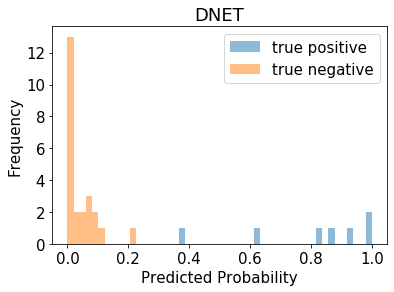



 50%|█████     | 1/2 [00:00<00:00,  3.75it/s]

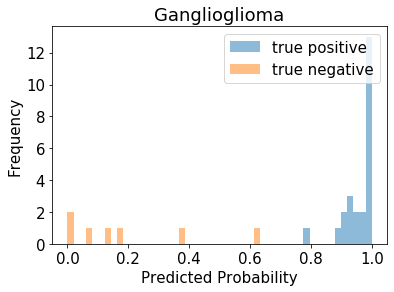



100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


In [62]:
evaluator.plot_probability_histograms(level=shared.enums.EvaluationLevel.slide, 
                                      dataset_type=shared.enums.DatasetType.validation, 
                                      font_size=15)



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.06it/s]

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


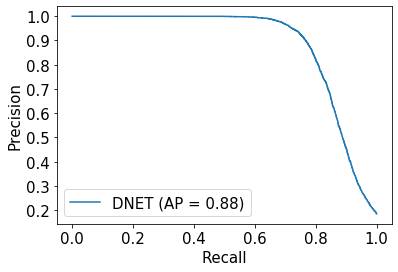

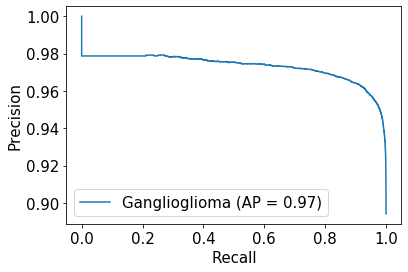

In [63]:
evaluator.plot_precision_recall_curves(level=shared.enums.EvaluationLevel.tile, 
                                       dataset_type=shared.enums.DatasetType.validation, font_size=15)









  0%|          | 0/2 [00:00<?, ?it/s]







100%|██████████| 2/2 [00:00<00:00, 19.03it/s]


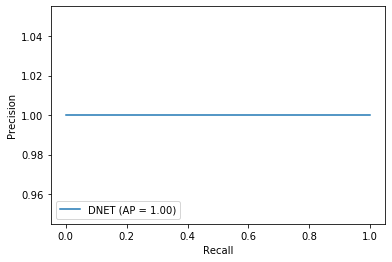

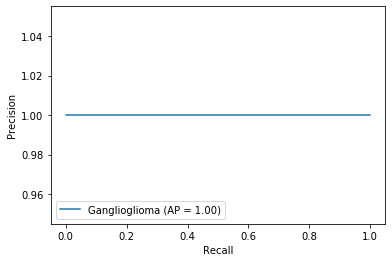

In [186]:
evaluator.plot_precision_recall_curves(level=shared.enums.EvaluationLevel.slide, 
                                       dataset_type=shared.enums.DatasetType.validation)

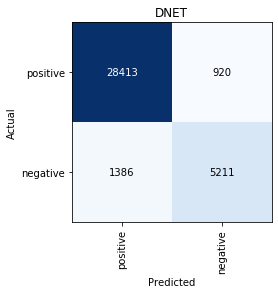

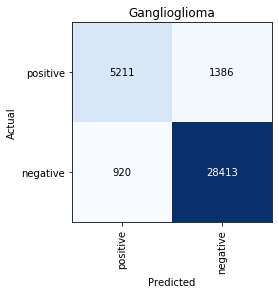

In [187]:
evaluator.plot_confusion_matrix(dataset_type=shared.enums.DatasetType.validation, 
                                level=shared.enums.EvaluationLevel.tile, font_size =)

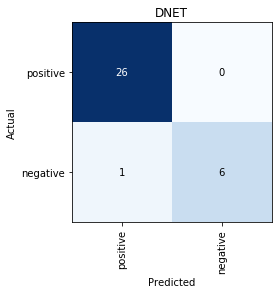

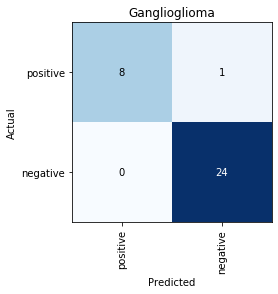

In [51]:
evaluator.plot_confusion_matrix(dataset_type=shared.enums.DatasetType.validation, 
                                level=shared.enums.EvaluationLevel.slide)









  0%|          | 0/2 [00:00<?, ?it/s]







 50%|█████     | 1/2 [00:00<00:00,  1.17it/s]







100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


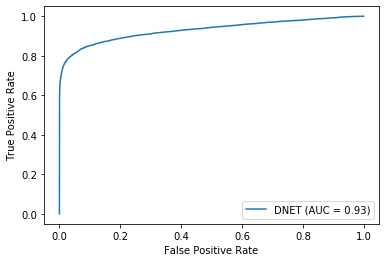

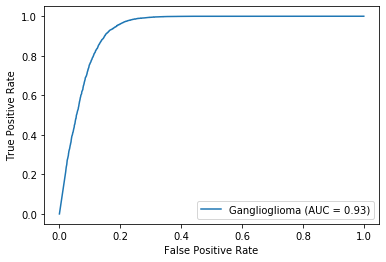

In [188]:
evaluator.plot_roc_curves(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.tile)


100%|██████████| 2/2 [00:00<00:00, 18.17it/s]


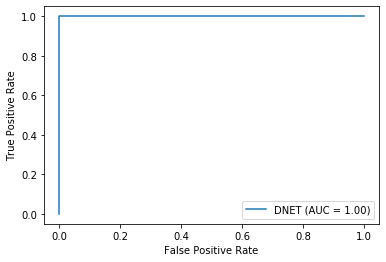

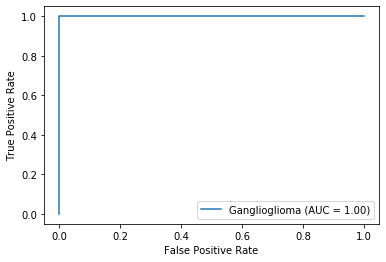

In [58]:
evaluator.plot_roc_curves(dataset_type=shared.enums.DatasetType.validation, level=shared.enums.EvaluationLevel.slide)

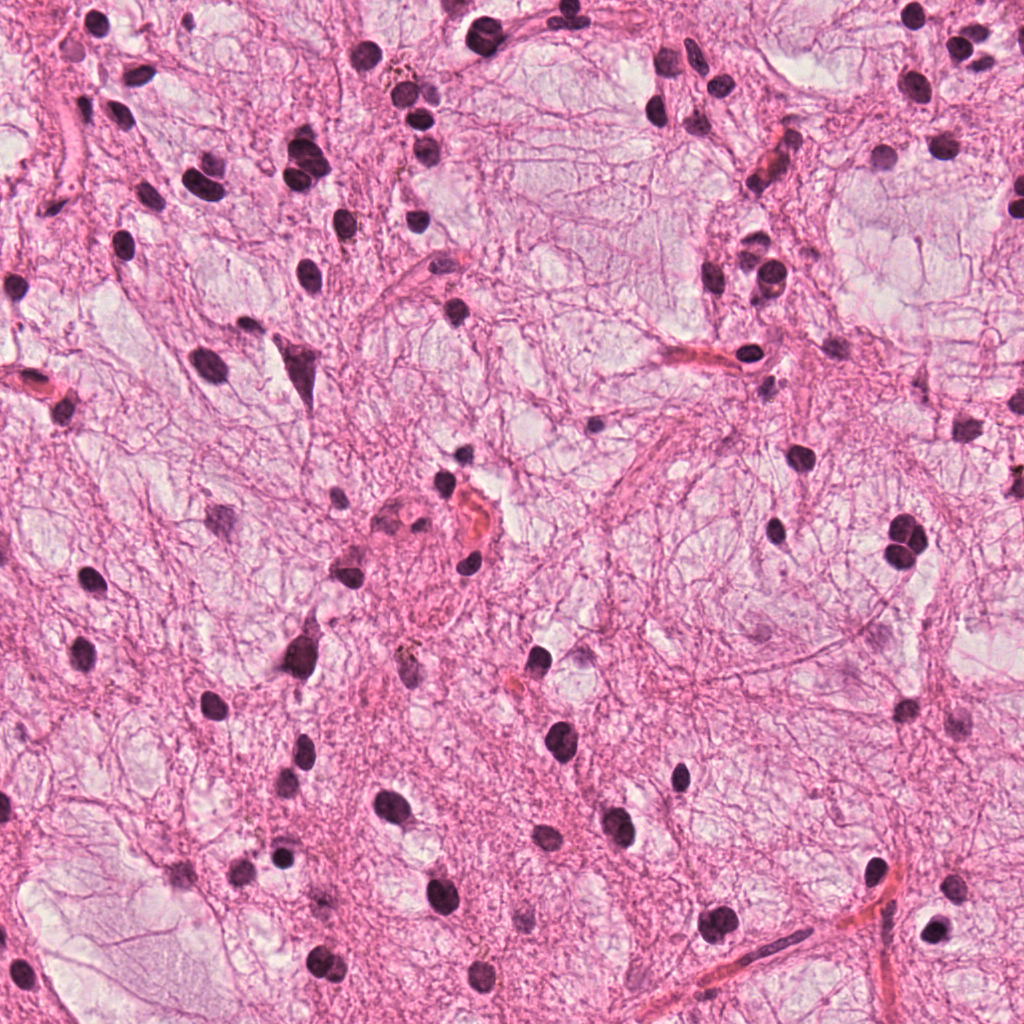

In [68]:
t.get_pil_image()

predicted percentages {'DNET': 0.9999712705612183, 'Ganglioglioma': 2.867009970941581e-05}
predicted classes: ['DNET']
targets: ['DNET']


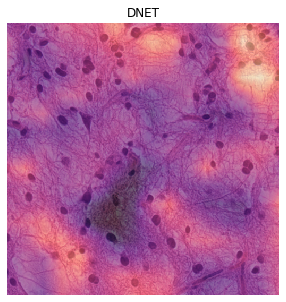

In [67]:
t = patient_manager.get_all_tiles()[42]
evaluator.plot_grad_cams(t)

In [ ]:
evaluator.plot_guided_grad_cams(tile=t)